# Lab 3: Matching, RANSAC and integration
This is a notebook, which could help you with testing fourth lab assignment.
It contains utility functions for visualization, some test input for the functions you needs to implement,
and the output of the reference solution for the same test input.

template functions for the assignment contain a short description of what the function is supposed to do,
and produce an incorrect output, which is nevertheless in proper format: type and shape.

You are not allowed to use kornia or opencv or any other library functions, which are specifically designed
to perform the operations requested in assignment

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch
import kornia
import cv2


def plot_torch(x, y, *kwargs):
    plt.plot(x.detach().cpu().numpy(), y.detach().cpu().numpy(), *kwargs)
    return

def imshow_torch(tensor,figsize=(8,6), *kwargs):
    plt.figure(figsize=figsize)
    plt.imshow(kornia.tensor_to_image(tensor), *kwargs)
    return

def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(kornia.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

def timg_load(fname, to_gray = True):
    img = cv2.imread(fname)
    with torch.no_grad():
        timg = kornia.image_to_tensor(img, False).float()
        if to_gray:
            timg = kornia.color.bgr_to_grayscale(timg)
        else:
            timg = kornia.color.bgr_to_rgb(timg)
    return timg


def keypoint_locations_to_opencv_kps(keypoint_locations, increase_scale=1.0):
    kpts = [cv2.KeyPoint(b_ch_sc_y_x[4].item(),
                         b_ch_sc_y_x[3].item(),
                         b_ch_sc_y_x[2].item()*increase_scale)
            for b_ch_sc_y_x in keypoint_locations if b_ch_sc_y_x[0].item() == 0]
    return kpts

def visualize_detections(img, keypoint_locations, img_idx = 0, increase_scale = 1.):
    # Select keypoints relevant to image   
    kpts = keypoint_locations_to_opencv_kps(keypoint_locations, increase_scale)
    vis_img = None
    vis_img = cv2.drawKeypoints(kornia.tensor_to_image(img).astype(np.uint8),
                                kpts,
                                vis_img, 
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(12,10))
    plt.imshow(vis_img)
    return


tensor([[ 0.0000,  1.0000],
        [ 1.0000,  1.0000],
        [-1.0000,  1.0000],
        [ 0.0000,  0.5000]])
tensor([[ 3.0000,  3.0000],
        [ 5.0000,  5.0000],
        [ 0.0000,  1.0000],
        [ 1.0000,  1.0000],
        [-1.0000,  1.0000],
        [ 0.0000,  0.5000],
        [ 2.0000,  2.0000]])


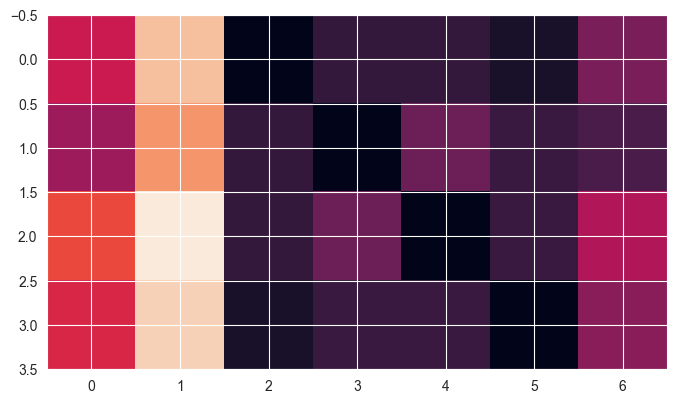

In [2]:
v1 = torch.tensor([[0,1],[1,1], [-1,1], [0,0.5]]).view(-1,2).float()
v2 = torch.cat([torch.tensor([[3,3.],[5,5.]]),v1, torch.tensor([[2.,2.]])], dim=0)
print (v1)
print (v2)
desc1=v1
desc2=v2
distance_matrix = torch.cdist(desc1,desc2)
imshow_torch(distance_matrix)

In [3]:
from matching import *

match_idxs, vals = match_snn(desc1, desc2, 0.8)
print (match_idxs, vals)


tensor([[0, 2],
        [1, 3],
        [2, 4],
        [3, 5]]) tensor([0., 0., 0., 0.])


In [4]:
match_snn(torch.ones((10, 2)), torch.ones((10, 2)))

(tensor([], size=(0, 2), dtype=torch.int64), tensor([]))

## Reference example

```python
from matching import *


match_idxs, vals = match_snn(desc1, desc2, 0.8)
print (match_idxs, vals)
```

    tensor([[0, 2],
            [1, 3],
            [2, 4],
            [3, 5]]) tensor([0., 0., 0., 0.])


In [5]:
#And other direction

from matching import *

desc1=v2
desc2=v1

match_idxs, vals = match_snn(desc1, desc2, 0.8)
print (match_idxs, vals)


tensor([[0, 1],
        [2, 0],
        [3, 1],
        [4, 2],
        [5, 3],
        [6, 1]]) tensor([0.7845, 0.0000, 0.0000, 0.0000, 0.0000, 0.6325])


In [6]:
desc2.shape

torch.Size([4, 2])

## Reference example

```python
#And other direction

from matching import *

desc1=v2
desc2=v1



match_idxs, vals = match_snn(desc1, desc2, 0.8)
print (match_idxs, vals)


```

    tensor([[0, 1],
            [2, 0],
            [3, 1],
            [4, 2],
            [5, 3],
            [6, 1]]) tensor([0.7845, 0.0000, 0.0000, 0.0000, 0.0000, 0.6325])


In [7]:
def detect_and_describe(img,
                        det='harris',
                        th=0.00001,
                        affine=False,
                        PS = 31):
    if det.lower() == 'harris':
        keypoint_locations = scalespace_harris(img, th, 20, 1.3)
        print('Found scale space')
    else:
        raise ValueError('Unknown detector, try harris')
    n_kp = keypoint_locations.size(0)
    A, img_idxs = affine_from_location(keypoint_locations)
    if affine:
        patches  = extract_affine_patches(img, A, img_idxs, 19, 5.0)
        aff_shape = estimate_patch_affine_shape(patches)
        dummy_angles = torch.zeros(n_kp,1, dtype=torch.float, device=img.device)
                                                          
        A, img_idxs = affine_from_location_and_orientation_and_affshape(keypoint_locations, 
                                                          dummy_angles,
                                                          aff_shape)
    patches =  extract_affine_patches(img, A, img_idxs, 19, 5.0)
    ori = estimate_patch_dominant_orientation(patches)
    if affine:
        A, img_idxs = affine_from_location_and_orientation_and_affshape(keypoint_locations, 
                                                  ori,
                                                  aff_shape)
    else:
        A, img_idxs = affine_from_location_and_orientation(keypoint_locations, 
                                                  ori)
    patches =  extract_affine_patches(img, A, img_idxs, PS, 10.0)
    descs = calc_sift_descriptor(patches)
    return keypoint_locations, descs, A


In [8]:
from local_descriptor import *
from local_detector import *
from matching import *

timg1 = timg_load('v_woman1.ppm', True)/255.
timg2 = timg_load('v_woman6.ppm', True)/255.


with torch.no_grad():
    keypoint_locations1, descs1, A1 = detect_and_describe(timg1)
    keypoint_locations2, descs2, A2 = detect_and_describe(timg2)
    match_idxs, vals = match_snn(descs1, descs2, 0.8)
    pts_matches = torch.cat([A1[match_idxs[:,0],:2,2], A2[match_idxs[:,1],:2,2]], dim=1) 


C:\Users\fs\Documents\GitHub\mpv-templates-backup\venv\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Found scale space


Sifting:   0%|          | 0/4 [00:00<?, ?it/s]


IndexError: The shape of the mask [28, 8, 7] at index 2 does not match the shape of the indexed tensor [28, 8, 8] at index 2

In [ ]:
def tentatives_to_opencv(match_idxs, vals):
    tentative_matches = [cv2.DMatch(i[0].item(), i[1].item(), vals[idx].item())
                         for idx,i in enumerate(match_idxs)]
    return tentative_matches

kps1  = keypoint_locations_to_opencv_kps(keypoint_locations1)
kps2  = keypoint_locations_to_opencv_kps(keypoint_locations2)

match_idxs, vals = match_snn(descs1, descs2, 0.8)
tentative_matches = tentatives_to_opencv(match_idxs, vals)


img_matches = np.empty((max(timg1.shape[2], timg2.shape[2]), 
                        timg1.shape[3]+timg2.shape[3], 3), dtype=np.uint8)
img1 = (kornia.tensor_to_image(timg1)*255.).astype(np.uint8)
img2 = (kornia.tensor_to_image(timg2)*255.).astype(np.uint8)

cv2.drawMatches(img1, kps1,
                img2, kps2,
                tentative_matches, img_matches, 
                flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,10))
plt.imshow(img_matches)


##  Reference example
```python
def tentatives_to_opencv(match_idxs, vals):
    tentative_matches = [cv2.DMatch(i[0].item(), i[1].item(), vals[idx]) for idx,i in enumerate(match_idxs)]
    return tentative_matches
    
kps1  = keypoint_locations_to_opencv_kps(keypoint_locations1)
kps2  = keypoint_locations_to_opencv_kps(keypoint_locations2)

match_idxs, vals = match_snn(descs1, descs2, 0.8)
tentative_matches = tentatives_to_opencv(match_idxs, vals)


img_matches = np.empty((max(timg1.shape[2], timg2.shape[2]), 
                        timg1.shape[3]+timg2.shape[3], 3), dtype=np.uint8)
img1 = (kornia.tensor_to_image(timg1)*255.).astype(np.uint8)
img2 = (kornia.tensor_to_image(timg2)*255.).astype(np.uint8)

cv2.drawMatches(img1, kps1,
                img2, kps2,
                tentative_matches, img_matches, 
                flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,10))
plt.imshow(img_matches)
```

![image.png](matching_and_ransac_files/att_00000.png)

In [ ]:
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentative_matches, H,  H_gt, inlier_mask, img1, img2):
    matchesMask = inlier_mask.ravel().tolist()
    h,w, ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 20)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2_tr,kps2,tentative_matches,None,**draw_params)
    plt.figure(figsize=(20,10))
    plt.imshow(img_out)
    return
H_gt = np.loadtxt('v_woman_H_1_6')
#Geometric verification (RANSAC)
from copy import deepcopy
def verify(tentative_matches, kps1, kps2):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentative_matches ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentative_matches ]).reshape(-1,2)
    H, inlier_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,1.0)
    return H, inlier_mask
    

H, inliers =  verify(tentative_matches, kps1, kps2)

draw_matches(kps1, kps2, tentative_matches, H, H_gt, inliers, cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB),
              cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB))

## Reference example

```python
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentative_matches, H,  H_gt, inlier_mask, img1, img2):
    matchesMask = inlier_mask.ravel().tolist()
    h,w, ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 20)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2_tr,kps2,tentative_matches,None,**draw_params)
    plt.figure(figsize=(20,10))
    plt.imshow(img_out)
    return
H_gt = np.loadtxt('v_woman_H_1_6')
#Geometric verification (RANSAC)
from copy import deepcopy
def verify(tentative_matches, kps1, kps2):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentative_matches ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentative_matches ]).reshape(-1,2)
    H, inlier_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,1.0)
    return H, inlier_mask
    

H, inliers =  verify(tentative_matches, kps1, kps2)

draw_matches(kps1, kps2, tentative_matches, H, H_gt, inliers, cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB),
              cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB))
```
![image.png](matching_and_ransac_files/att_00001.png)

# Now everything together

In [ ]:
from local_descriptor import *
from local_detector import *
from matching import *
from ransac import *


timg1 = timg_load('v_woman1.ppm', True)/255.
timg2 = timg_load('v_woman6.ppm', True)/255.


with torch.no_grad():
    keypoint_locations1, descs1, A1 = detect_and_describe(timg1)
    keypoint_locations2, descs2, A2 = detect_and_describe(timg2)
    match_idxs, vals = match_snn(descs1, descs2, 0.85) 
    tentative_matches = tentatives_to_opencv(match_idxs, vals)
    pts_matches = torch.cat([A1[match_idxs[:,0],:2,2], A2[match_idxs[:,1],:2,2]], dim=1)
    H, inl = ransac_h(pts_matches, 4.0, 0.99, 10000)

draw_matches(kps1, kps2, tentative_matches,
             H.detach().cpu().numpy(),
             H_gt,
             inl.cpu().numpy(),
             cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB),
             cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB))

# Reference solution 

```python
from local_descriptor import *
from local_detector import *
from matching import *
from ransac import *


timg1 = timg_load('v_woman1.ppm', True)/255.
timg2 = timg_load('v_woman6.ppm', True)/255.


with torch.no_grad():
    keypoint_locations1, descs1, A1 = detect_and_describe(timg1)
    keypoint_locations2, descs2, A2 = detect_and_describe(timg2)
    match_idxs, vals = match_smnn(descs1, descs2, 0.85) 
    tentative_matches = tentatives_to_opencv(match_idxs, vals)
    pts_matches = torch.cat([A1[match_idxs[:,0],:2,2], A2[match_idxs[:,1],:2,2]], dim=1)
    H, inl = ransac_h(pts_matches, 4.0, 0.99, 10000)

draw_matches(kps1, kps2, tentative_matches,
             H.detach().cpu().numpy(),
             H_gt,
             inl.cpu().numpy(),
             cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB),
             cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB))
```
![image.png](matching_and_ransac_files/att_00002.png)

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from local_descriptor import *
from local_detector import *
from matching import *
from ransac import *
rand = torch.tensor([[0,0,0,0,], [1,1,1,1], [1,0,1,0], [0,1,0,1], [0,0,1,1]]).float()
print(rand)
H = torch.eye(3)
hdist(H, rand)

In [ ]:
pts = torch.tensor([[0.2388, 0.5217, 1.7051, 1.7667],
        [2.3542, 0.7206, 5.5262, 3.1243],
        [0.9210, 2.7358, 4.9290, 5.4027],
        [2.1559, 2.4843, 6.8188, 5.6481]])
getH(pts)

In [ ]:
from kornia.geometry.homography import find_homography_dlt
find_homography_dlt(pts[:,:2][None], pts[:,2:][None], solver='svd')

In [ ]:
getH(torch.tensor([[0,0,0,0,], [1,1,1,1], [1,0,1,0], [0,1,0,1]]).float())

In [ ]:
torch.square(v1 - v2[:4, :]).sum(dim=1), v1, v2

In [ ]:
3**2+2**2